# This code represents a trading strategy for 1 hour trading intervals
# The predictor is the low price of the DOGE cryptocurrency and the minimum threshold is -0.5

In [1]:
################# IMPORTS AND SETUP ##############################


from binance import Client
import pandas as pd
from supporting_functionsM2 import *
from API_KEYS2 import get_keys

# Setting up binance client
KEY, SECRET = get_keys()
client = Client(KEY, SECRET)

# Defining setup variables for creating dataset
# start = "1513724400" # 20.12.2017
start = "1483225200" # 01.01.2017
periods = 101 # approx 8 years
TICKER = "DOGEUSDT"
options = ["high", "low", "close", "volume"] # BASE OPTIONS
EPOCHS=5
THRESHOLD=-0.5 # Threshold value for lableling, ie. BTCUSDT:close = 0.5 > 0.0 => label = 1, if BTCUSDT:close = -0.5 < 0.0 => 0
PREDICTOR=f"{TICKER}:low"
TIME = f"{TICKER}:time"

In [2]:
################# DOWNLOADING RAW DATA ##########################################

periods = periods
LIMIT = 720 # 720h = 30 days
start1 = start
end1 = next_30_days_unix_timestamp(start1)

############################################ DOWNLOADING DATA ###################################################################### 
data = pd.DataFrame(columns=["time", "open", "high", "low", "close", "volume"])

# downloading the first set of candlestick lines
klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

# Converting data from list to pandas dataframe
new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])
data = pd.concat([data, new_data], ignore_index=True)

for i in range(periods - 1):
    # Moving the start and end interval to next day
    start1 = next_30_days_unix_timestamp(start1)
    end1 = next_30_days_unix_timestamp(start1) 

    # downloading candlestick lines
    klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

    # Converting data from list to pandas dataframe
    new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])

    # concatinating the new data with the existing data
    data = pd.concat([data, new_data], ignore_index=True)

# converting all time values from unix to readable string, not important, just for visual purposes and fact checking
data["time"] = data["time"].apply(unix_to_datetime_string) #converting time from 

raw_data = data
display(raw_data)


,time,open,high,low,close,volume
0,2019-07-05 12:00:00,0.00449000,0.00460000,0.00376000,0.00392490,949430724.00000000
1,2019-07-05 13:00:00,0.00391530,0.00392840,0.00376500,0.00383530,159004267.00000000
2,2019-07-05 14:00:00,0.00384500,0.00392000,0.00381390,0.00384130,105517060.00000000
3,2019-07-05 15:00:00,0.00383730,0.00386890,0.00371000,0.00373790,100804728.00000000
4,2019-07-05 16:00:00,0.00372760,0.00373380,0.00363640,0.00366640,120261079.00000000
...,...,...,...,...,...,...
50713,2025-04-18 18:00:00,0.15740000,0.15880000,0.15721000,0.15815000,20314214.00000000
50714,2025-04-18 19:00:00,0.15814000,0.15836000,0.15755000,0.15790000,15034177.00000000
50715,2025-04-18 20:00:00,0.15790000,0.15838000,0.15749000,0.15811000,10815042.00000000
50716,2025-04-18 21:00:00,0.15812000,0.15895000,0.15768000,0.15880000,11345426.00000000


In [11]:
raw_close = raw_data['close'].to_list()
print(f"PERCENT RETURN EVALUATION SET: {percent_difference(float(raw_close[-10000]), float(raw_close[-1]))}")

PERCENT RETURN EVALUATION SET: 72.2409848567382


In [3]:
########################################## PREPROCESSING DATA ####################################################################

# New dataobject for storing processed data
# processed_data = {f"{TICKER}:time": [], f"{TICKER}:open": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}
processed_data = {f"{TICKER}:time": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}

for i, o in enumerate(raw_data["open"]): #o == open, the open price value of the candle stick
    if i == 0: #Skipping the first hour to calculate the percent diff using this hour
        continue

    if o == 0:
        continue

    processed_data[f"{TICKER}:time"].append(raw_data["time"][i]) #time is the same
    # processed_data[f"{TICKER}:open"].append(percent_difference(float(data["open"][i-1]), float(o))) # percent difference between the opening price of the prior candlestick vs. open of current candle
    processed_data[f"{TICKER}:high"].append(percent_difference(float(o), float(raw_data["high"][i]))) # percent diff between open and high
    processed_data[f"{TICKER}:low"].append(percent_difference(float(o), float(raw_data["low"][i]))) # percent diff between open and low
    processed_data[f"{TICKER}:close"].append(percent_difference(float(o), float(raw_data["close"][i]))) # percent diff between open and close
    processed_data[f"{TICKER}:volume"].append(percent_difference(float(raw_data["volume"][i-1]), float(raw_data["volume"][i]))) # percent difference between the colume of the prior candlestick vs. open of current candle


# processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:open", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
display(processed_data)

,DOGEUSDT:time,DOGEUSDT:high,DOGEUSDT:low,DOGEUSDT:close,DOGEUSDT:volume
0,2019-07-05 13:00:00,0.334585,-3.838786,-2.043266,-83.252673
1,2019-07-05 14:00:00,1.950585,-0.808843,-0.096229,-33.638850
2,2019-07-05 15:00:00,0.823496,-3.317437,-2.590363,-4.465943
3,2019-07-05 16:00:00,0.166327,-2.446614,-1.641807,19.301030
4,2019-07-05 17:00:00,0.573927,-2.978956,-0.858158,23.294189
...,...,...,...,...,...
50712,2025-04-18 18:00:00,0.889454,-0.120712,0.476493,-8.592708
50713,2025-04-18 19:00:00,0.139117,-0.373087,-0.151764,-25.991835
50714,2025-04-18 20:00:00,0.303990,-0.259658,0.132996,-28.063625
50715,2025-04-18 21:00:00,0.524918,-0.278270,0.430053,4.904133


In [ ]:
############################# STATISTICAL ANALYSIS OF PROCESSED DATA #######################################
import statistics as st

low_data_processed = processed_data[f"{TICKER}:low"].to_list()
low_data_processed = low_data_processed[:-10000]
print(f"TOTAL DATAPOINTS: {len(low_data_processed)}")
print(f"MEAN LOW: {st.mean(low_data_processed)}")
print(f"MEDIAN LOW: {st.median(low_data_processed)}")

print(f"MIN LOW IN DATASET: {min(low_data_processed)}")
print(f"OCCURRENCES UNDER -0.5: {sum(x < -0.5 for x in low_data_processed)} - PERCENT OF DATASET: {round(sum(x < -0.5 for x in low_data_processed) / len(low_data_processed), 2)}%")
print(f"OCCURRENCES UNDER -0.6: {sum(x < -0.6 for x in low_data_processed)} - PERCENT OF DATASET: {round(sum(x < -0.6 for x in low_data_processed) / len(low_data_processed), 2)}%")
print(f"OCCURRENCES UNDER -0.7: {sum(x < -0.7 for x in low_data_processed)} - PERCENT OF DATASET: {round(sum(x < -0.7 for x in low_data_processed) / len(low_data_processed), 2)}%")
print(f"OCCURRENCES UNDER -0.8: {sum(x < -0.8 for x in low_data_processed)} - PERCENT OF DATASET: {round(sum(x < -0.8 for x in low_data_processed) / len(low_data_processed), 2)}%")
print(f"OCCURRENCES UNDER -0.9: {sum(x < -0.9 for x in low_data_processed)} - PERCENT OF DATASET: {round(sum(x < -0.9 for x in low_data_processed) / len(low_data_processed), 2)}%")
print(f"OCCURRENCES UNDER -1: {sum(x < -1 for x in low_data_processed)} - PERCENT OF DATASET: {round(sum(x < -1 for x in low_data_processed) / len(low_data_processed), 2)}%")
print("----------------------------------------------------------------------")

print("EVALUATION DATASET")
low_data_processed = low_data_processed[-10000:]
print(f"TOTAL DATAPOINTS: {len(low_data_processed)}")
print(f"MEAN LOW: {st.mean(low_data_processed)}")
print(f"MEDIAN LOW: {st.median(low_data_processed)}")

print(f"MIN LOW IN DATASET: {min(low_data_processed)}")
print(f"OCCURRENCES UNDER -0.5: {sum(x < -0.5 for x in low_data_processed)} - PERCENT OF DATASET: {round(sum(x < -0.5 for x in low_data_processed) / len(low_data_processed), 2)}%")
print(f"OCCURRENCES UNDER -0.6: {sum(x < -0.6 for x in low_data_processed)} - PERCENT OF DATASET: {round(sum(x < -0.6 for x in low_data_processed) / len(low_data_processed), 2)}%")
print(f"OCCURRENCES UNDER -0.7: {sum(x < -0.7 for x in low_data_processed)} - PERCENT OF DATASET: {round(sum(x < -0.7 for x in low_data_processed) / len(low_data_processed), 2)}%")
print(f"OCCURRENCES UNDER -0.8: {sum(x < -0.8 for x in low_data_processed)} - PERCENT OF DATASET: {round(sum(x < -0.8 for x in low_data_processed) / len(low_data_processed), 2)}%")
print(f"OCCURRENCES UNDER -0.9: {sum(x < -0.9 for x in low_data_processed)} - PERCENT OF DATASET: {round(sum(x < -0.9 for x in low_data_processed) / len(low_data_processed), 2)}%")
print(f"OCCURRENCES UNDER -1: {sum(x < -1 for x in low_data_processed)} - PERCENT OF DATASET: {round(sum(x < -1 for x in low_data_processed) / len(low_data_processed), 2)}%")
print("----------------------------------------------------------------------")

TOTAL DATAPOINTS: 50717
MIN LOW IN DATASET: -44.218675685673524
OCCURRENCES UNDER -0.5: 23822 - PERCENT OF DATASET: 0.47%
OCCURRENCES UNDER -0.6: 20463 - PERCENT OF DATASET: 0.4%
OCCURRENCES UNDER -0.7: 17738 - PERCENT OF DATASET: 0.35%
OCCURRENCES UNDER -0.8: 15344 - PERCENT OF DATASET: 0.3%
OCCURRENCES UNDER -0.9: 13456 - PERCENT OF DATASET: 0.27%
OCCURRENCES UNDER -1: 11798 - PERCENT OF DATASET: 0.23%
----------------------------------------------------------------------


In [5]:
########################### LABELING THE DATA ##################################


# column_labels = ["BTCUSDT:time"] # name of the columns for the return dataframe
column_labels = ["time"] # name of the columns for the return dataframe

# filling up the list with labels for the columns
for roundd in range(EPOCHS):
    for option in options:
        column_labels.append(f"{TICKER}:{option}{roundd}")

column_labels.append("Label")


# filling up list of data, row by row in the dataset
labelled_data_rows = [] # this list stores all the rows filled with all the data
for i in range(len(processed_data[TIME]) - EPOCHS): #looping from the third element to the third last element, with stepsize 1, if epoch=3
    data_row = []

    data_row.append(processed_data[TIME][i + EPOCHS - 1])

    for t in range(EPOCHS):
        for option in options:
            data_row.append(processed_data[f"{TICKER}:{option}"][i + t])

    if processed_data[PREDICTOR][i + EPOCHS] < THRESHOLD: # here we use the threshold
        data_row.append(1)
    else:
        data_row.append(0)

    labelled_data_rows.append(data_row)


labelled_data_frame = pd.DataFrame(labelled_data_rows, columns=column_labels)
display(labelled_data_frame)

,time,DOGEUSDT:high0,DOGEUSDT:low0,DOGEUSDT:close0,DOGEUSDT:volume0,DOGEUSDT:high1,DOGEUSDT:low1,DOGEUSDT:close1,DOGEUSDT:volume1,DOGEUSDT:high2,...,DOGEUSDT:volume2,DOGEUSDT:high3,DOGEUSDT:low3,DOGEUSDT:close3,DOGEUSDT:volume3,DOGEUSDT:high4,DOGEUSDT:low4,DOGEUSDT:close4,DOGEUSDT:volume4,Label
0,2019-07-05 17:00:00,0.334585,-3.838786,-2.043266,-83.252673,1.950585,-0.808843,-0.096229,-33.638850,0.823496,...,-4.465943,0.166327,-2.446614,-1.641807,19.301030,0.573927,-2.978956,-0.858158,23.294189,1
1,2019-07-05 18:00:00,1.950585,-0.808843,-0.096229,-33.638850,0.823496,-3.317437,-2.590363,-4.465943,0.166327,...,19.301030,0.573927,-2.978956,-0.858158,23.294189,3.009719,-1.170753,0.508063,-60.244488,0
2,2019-07-05 19:00:00,0.823496,-3.317437,-2.590363,-4.465943,0.166327,-2.446614,-1.641807,19.301030,0.573927,...,23.294189,3.009719,-1.170753,0.508063,-60.244488,2.330439,-0.096186,1.354842,24.010361,1
3,2019-07-05 20:00:00,0.166327,-2.446614,-1.641807,19.301030,0.573927,-2.978956,-0.858158,23.294189,3.009719,...,-60.244488,2.330439,-0.096186,1.354842,24.010361,1.355638,-1.751484,0.612748,-42.029380,1
4,2019-07-05 21:00:00,0.573927,-2.978956,-0.858158,23.294189,3.009719,-1.170753,0.508063,-60.244488,2.330439,...,24.010361,1.355638,-1.751484,0.612748,-42.029380,1.835134,-0.921609,-0.021558,8.045463,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50707,2025-04-18 17:00:00,0.346065,-0.378108,0.281979,3.859341,0.268422,-0.300377,0.121429,-21.378098,0.076599,...,3.466447,0.402942,-0.179085,0.287816,-3.202324,0.471909,-0.204069,0.376252,76.555233,0
50708,2025-04-18 18:00:00,0.268422,-0.300377,0.121429,-21.378098,0.076599,-0.791523,-0.191498,3.466447,0.402942,...,-3.202324,0.471909,-0.204069,0.376252,76.555233,0.889454,-0.120712,0.476493,-8.592708,0
50709,2025-04-18 19:00:00,0.076599,-0.791523,-0.191498,3.466447,0.402942,-0.179085,0.287816,-3.202324,0.471909,...,76.555233,0.889454,-0.120712,0.476493,-8.592708,0.139117,-0.373087,-0.151764,-25.991835,0
50710,2025-04-18 20:00:00,0.402942,-0.179085,0.287816,-3.202324,0.471909,-0.204069,0.376252,76.555233,0.889454,...,-8.592708,0.139117,-0.373087,-0.151764,-25.991835,0.303990,-0.259658,0.132996,-28.063625,0


# Model Training

This code block divides the dataset into a training dataset and trains a new model using the **AutoGluon Tabular** predictor.

In [6]:
################################ TRAINING NEW MODEL #######################################
from autogluon.tabular import TabularDataset, TabularPredictor

# defining training size and colums to use for training within the labelled dataset
VALIDATION_SIZE = 10000
columns_to_use = [f"{TICKER}:high0", f"{TICKER}:low0", f"{TICKER}:close0", f"{TICKER}:volume0", f"{TICKER}:high1", f"{TICKER}:low1", f"{TICKER}:close1", f"{TICKER}:volume1", f"{TICKER}:high2", f"{TICKER}:low2", f"{TICKER}:close2", f"{TICKER}:volume2", f"{TICKER}:high3", f"{TICKER}:low3", f"{TICKER}:close3", f"{TICKER}:volume3", f"{TICKER}:high4", f"{TICKER}:low4", f"{TICKER}:close4", f"{TICKER}:volume4", "Label"]
LABEL = "Label"

# defining training data
training_dataframe = labelled_data_frame.iloc[:-VALIDATION_SIZE].copy()
train_data_frame2 = training_dataframe[columns_to_use]
train_tabular_dataset = TabularDataset(train_data_frame2)

# # Training model -> TabularPredictor
# predictor = TabularPredictor(label=label, eval_metric="balanced_accuracy", positive_class=1).fit(train_tabular_dataset, num_bag_folds=5, num_bag_sets=5, num_stack_levels=3)
# predictor = TabularPredictor(label=label, eval_metric="accuracy").fit(train_tabular_dataset, presets="high_quality")
predictor = TabularPredictor(label=LABEL).fit(train_tabular_dataset)



c:\Users\47981\Desktop\MasterThesis\Repo\MasterThesis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels\ag-20250516_110146"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       6.91 GB / 15.92 GB (43.4%)
Disk Space Avail:   89.24 GB / 475.69 GB (18.8%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Defaul

# Model Evaluation

This code block divides the dataset into a validation dataset and evaluates the model using the **AutoGluons** inbuilt evaluation library. In addition the model is backtested using the validation set to measure its performance and calulate its "expected return" over the period.

In [7]:
#################### MODEL EVALUATION ################################

# Defining the testing set using the training size and columns to use
testing_dataframe = labelled_data_frame.tail(VALIDATION_SIZE).copy()
#display(testing_dataframe)
test_data_frame2 = testing_dataframe[columns_to_use]
test_tabular_dataset = TabularDataset(test_data_frame2)

######## Making predictions
y_pred = predictor.predict(test_tabular_dataset.drop(columns=[LABEL]))
display(y_pred)


#### Evaluation
eval_report = predictor.evaluate(test_tabular_dataset, detailed_report=True)
display(eval_report)

feature_importance = predictor.feature_importance(test_tabular_dataset)
display(feature_importance)


40712    1
40713    1
40714    1
40715    1
40716    1
        ..
50707    0
50708    0
50709    0
50710    0
50711    0
Name: Label, Length: 10000, dtype: int64

{'accuracy': 0.6259,
 'balanced_accuracy': 0.623196077070221,
 'mcc': 0.24706533838902073,
 'roc_auc': 0.6743482432560985,
 'f1': 0.6542833379539784,
 'precision': 0.6444565811032222,
 'recall': 0.6644144144144144,
 'confusion_matrix':       0     1
 0  2719  1953
 1  1788  3540,
 'classification_report': {'0': {'precision': 0.6032837807854449,
   'recall': 0.5819777397260274,
   'f1-score': 0.5924392635363329,
   'support': 4672.0},
  '1': {'precision': 0.6444565811032222,
   'recall': 0.6644144144144144,
   'f1-score': 0.6542833379539784,
   'support': 5328.0},
  'accuracy': 0.6259,
  'macro avg': {'precision': 0.6238701809443336,
   'recall': 0.623196077070221,
   'f1-score': 0.6233613007451557,
   'support': 10000.0},
  'weighted avg': {'precision': 0.6252206487947567,
   'recall': 0.6259,
   'f1-score': 0.6253897863860544,
   'support': 10000.0}}}

Computing feature importance via permutation shuffling for 20 features using 5000 rows with 5 shuffle sets...
	39.17s	= Expected runtime (7.83s per shuffle set)
	7.72s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
DOGEUSDT:low4,0.02732,0.009106,0.001285,5,0.046069,0.008571
DOGEUSDT:high4,0.01152,0.004625,0.002546,5,0.021043,0.001997
DOGEUSDT:low3,0.00776,0.001596,0.000203,5,0.011047,0.004473
DOGEUSDT:high0,0.00520,0.003311,0.012311,5,0.012017,-0.001617
DOGEUSDT:high3,0.00380,0.002345,0.011147,5,0.008629,-0.001029
DOGEUSDT:close4,0.00240,0.004409,0.145220,5,0.011478,-0.006678
DOGEUSDT:high1,0.00240,0.002905,0.069215,5,0.008382,-0.003582
DOGEUSDT:low0,0.00200,0.001131,0.008389,5,0.004330,-0.000330
DOGEUSDT:high2,0.00132,0.001927,0.100144,5,0.005287,-0.002647
DOGEUSDT:low1,0.00064,0.001802,0.235803,5,0.004351,-0.003071


In [14]:
import re
import pandas as pd

METRIC_RE = re.compile(r":([a-zA-Z]+?)(\d+)$")   # capture metric & hour suffix


def analyze_feature_importance(feature_names, importances):
    """
    Print a short report on a model’s feature-importance vector.

    Parameters
    ----------
    feature_names : list[str]
        All feature names, e.g. ["SOLUSDT:high4", "SOLUSDT:low2", ...]
    importances : list[float]
        Matching importance values, same length/order as `feature_names`
    """
    if len(feature_names) != len(importances):
        raise ValueError("feature_names and importances must be the same length!")

    # ── Build a DataFrame ────────────────────────────────────────────────────
    df = pd.DataFrame(
        {"feature": feature_names, "importance": importances}
    ).assign(
        metric=lambda d: d["feature"].str.extract(METRIC_RE)[0].str.lower(),
        hour=lambda d: pd.to_numeric(
            d["feature"].str.extract(METRIC_RE)[1], errors="coerce"
        ),
    )

    # Drop rows we could not parse
    df = df.dropna(subset=["metric", "hour"]).copy()
    df["hour"] = df["hour"].astype(int)

    # ── 1. % of positive importances ────────────────────────────────────────
    pct_pos = (df["importance"] > 0).mean() * 100

    # ── 2. Rank by hour (sum of importances per lag) ────────────────────────
    hour_scores = df.groupby("hour")["importance"].sum().sort_values(ascending=False)
    hour_ranking = hour_scores.index.tolist()

    # ── 3. Rank by metric (sum of importances per metric) ───────────────────
    metric_scores = (
        df.groupby("metric")["importance"].sum().sort_values(ascending=False)
    )
    metric_ranking = metric_scores.index.tolist()

    # ── Report ──────────────────────────────────────────────────────────────
    print(f"{pct_pos:.1f}% of the {len(df)} features have **positive** importance.\n")

    print("Ranking by HOUR (most → least important):")
    for i, h in enumerate(hour_ranking, 1):
        print(f"  {i}. h{h:<1}   sum importance = {hour_scores[h]:.6f}")

    print("\nRanking by METRIC (most → least important):")
    for i, m in enumerate(metric_ranking, 1):
        print(f"  {i}. {m:<6} sum importance = {metric_scores[m]:.6f}")

    top_features = (
        df.loc[df["importance"].abs().sort_values(ascending=False).index]
        .head(5)[["feature", "importance"]]
    )
    print("\nTop 5 individual features:")
    for feat, imp in top_features.itertuples(index=False):
        print(f"  {feat:<25} {imp:.6f}")




analyze_feature_importance(feature_importance.index.to_list(), feature_importance['importance'].to_list())

70.0% of the 20 features have **positive** importance.

Ranking by HOUR (most → least important):
  1. h4   sum importance = 0.039040
  2. h3   sum importance = 0.011080
  3. h0   sum importance = 0.007560
  4. h1   sum importance = 0.002000
  5. h2   sum importance = 0.000680

Ranking by METRIC (most → least important):
  1. low    sum importance = 0.038280
  2. high   sum importance = 0.024240
  3. close  sum importance = 0.000120
  4. volume sum importance = -0.002280

Top 5 individual features:
  DOGEUSDT:low4             0.027320
  DOGEUSDT:high4            0.011520
  DOGEUSDT:low3             0.007760
  DOGEUSDT:high0            0.005200
  DOGEUSDT:high3            0.003800


In [8]:
# ANALYSIS OF PREDICTIONS AND PROBABILITIES

import statistics as st

# making and processing probabilities from evaluation dataset
y_prob = predictor.predict_proba(test_tabular_dataset.drop(columns=[LABEL]))

validation_probabilities = pd.DataFrame(y_prob).reset_index(drop=True) # probability for each prediction
validation_predictions = pd.DataFrame(y_pred).reset_index(drop=True)
validation_dataset = pd.DataFrame(test_data_frame2).reset_index(drop=True)
display(validation_probabilities)
display(validation_predictions)
display(validation_dataset)

print(f"MEAN PROB 1 CLASSIFICATION: {st.mean(validation_probabilities[1].to_list())}")
print(f"MAX PROB 1 CLASSIFICATION: {max(validation_probabilities[1].to_list())}")
print(f"MIN PROB 1 CLASSIFICATION: {min(validation_probabilities[1].to_list())}")

count_above_07 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.7)
print("COUNT OF NUMBERS > 0.7:", count_above_07)

count_above_08 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.8)
print("COUNT OF NUMBERS > 0.8:", count_above_08)

count_above_09 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.9)
print("COUNT OF NUMBERS > 0.9:", count_above_09)








,0,1
0,0.407040,0.592960
1,0.408864,0.591136
2,0.342529,0.657471
3,0.242648,0.757352
4,0.328708,0.671292
...,...,...
9995,0.753928,0.246072
9996,0.700301,0.299699
9997,0.704278,0.295722
9998,0.779609,0.220391


,Label
0,1
1,1
2,1
3,1
4,1
...,...
9995,0
9996,0
9997,0
9998,0


,DOGEUSDT:high0,DOGEUSDT:low0,DOGEUSDT:close0,DOGEUSDT:volume0,DOGEUSDT:high1,DOGEUSDT:low1,DOGEUSDT:close1,DOGEUSDT:volume1,DOGEUSDT:high2,DOGEUSDT:low2,...,DOGEUSDT:volume2,DOGEUSDT:high3,DOGEUSDT:low3,DOGEUSDT:close3,DOGEUSDT:volume3,DOGEUSDT:high4,DOGEUSDT:low4,DOGEUSDT:close4,DOGEUSDT:volume4,Label
0,1.118693,-0.357982,0.850207,112.214803,0.565724,-1.131448,-1.009429,16.810482,1.478992,-0.201681,...,-35.055935,1.447823,-0.089097,1.058024,-3.293986,0.495977,-0.242478,0.484955,-28.375072,1
1,0.565724,-1.131448,-1.009429,16.810482,1.478992,-0.201681,0.593838,-35.055935,1.447823,-0.089097,...,-3.293986,0.495977,-0.242478,0.484955,-28.375072,0.702062,-0.614305,0.691093,119.537053,1
2,1.478992,-0.201681,0.593838,-35.055935,1.447823,-0.089097,1.058024,-3.293986,0.495977,-0.242478,...,-28.375072,0.702062,-0.614305,0.691093,119.537053,0.882449,-0.577405,0.675455,-1.512026,0
3,1.447823,-0.089097,1.058024,-3.293986,0.495977,-0.242478,0.484955,-28.375072,0.702062,-0.614305,...,119.537053,0.882449,-0.577405,0.675455,-1.512026,4.339357,-0.183963,3.430365,192.523631,1
4,0.495977,-0.242478,0.484955,-28.375072,0.702062,-0.614305,0.691093,119.537053,0.882449,-0.577405,...,-1.512026,4.339357,-0.183963,3.430365,192.523631,0.941620,-1.056706,0.418498,-37.432668,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.346065,-0.378108,0.281979,3.859341,0.268422,-0.300377,0.121429,-21.378098,0.076599,-0.791523,...,3.466447,0.402942,-0.179085,0.287816,-3.202324,0.471909,-0.204069,0.376252,76.555233,0
9996,0.268422,-0.300377,0.121429,-21.378098,0.076599,-0.791523,-0.191498,3.466447,0.402942,-0.179085,...,-3.202324,0.471909,-0.204069,0.376252,76.555233,0.889454,-0.120712,0.476493,-8.592708,0
9997,0.076599,-0.791523,-0.191498,3.466447,0.402942,-0.179085,0.287816,-3.202324,0.471909,-0.204069,...,76.555233,0.889454,-0.120712,0.476493,-8.592708,0.139117,-0.373087,-0.151764,-25.991835,0
9998,0.402942,-0.179085,0.287816,-3.202324,0.471909,-0.204069,0.376252,76.555233,0.889454,-0.120712,...,-8.592708,0.139117,-0.373087,-0.151764,-25.991835,0.303990,-0.259658,0.132996,-28.063625,0


MEAN PROB 1 CLASSIFICATION: 0.5257048698171973
MAX PROB 1 CLASSIFICATION: 0.9444857835769653
MIN PROB 1 CLASSIFICATION: 0.06921788305044174
COUNT OF NUMBERS > 0.7: 1770
COUNT OF NUMBERS > 0.8: 524
COUNT OF NUMBERS > 0.9: 26


NUMBER OF TRADES: 524
ACCURACY: 85.5%
RETURN: -33.93%
SHARP RATIO: -1.4434437669121547
SHARP RATIO ONLY HOLDING ASSET: 1.0647572029090704
MEAN RETURN BAD TRADES: -2.2668026315789476
----------------------------------
-2.596
-0.271
-2.6
-0.878
-1.986
-1.909
-3.205
-2.088
-10.642
-1.297
-2.087
-1.576
-3.109
-0.182
-4.289
-1.18
-3.49
-3.716
-3.187
-0.375
-2.67
-0.974
-4.975
-1.471
-1.176
-0.635
-2.198
-2.412
-0.972
-1.793
-0.725
-1.122
-1.557
-1.122
-4.985
-1.649
-0.289
-0.703
-3.319
-1.185
-1.511
-5.965
-1.772
-1.35
-0.163
-2.623
-3.018
-4.793
-7.522
-3.926
-3.505
-1.453
-0.59
-5.519
-1.913
-2.178
-2.646
-1.439
-3.464
-1.796
-0.855
-2.923
-0.008
-0.862
-1.683
-2.81
-6.723
-0.905
-1.158
-1.365
-1.571
-1.003
-4.423
-0.627
-0.464
-1.156


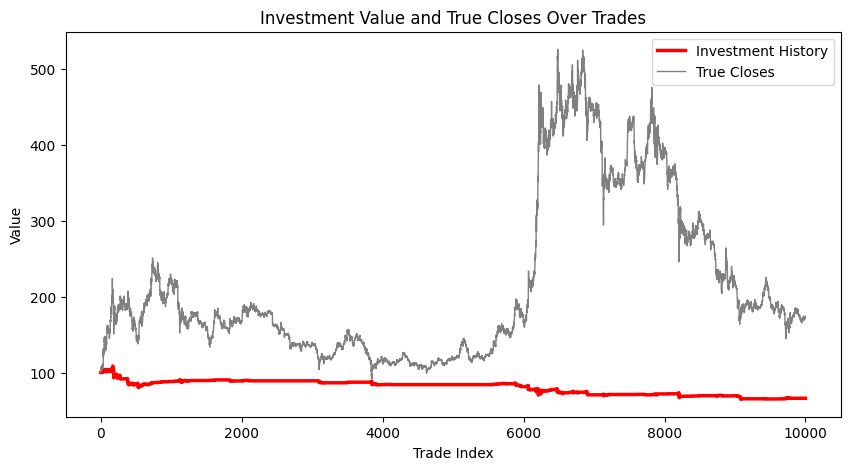

In [ ]:
import matplotlib.pyplot as plt

# --- Constants ---
MINIMUM_PROBABILITY = 0.7
LEVERAGE = 1
FEE = 0.0
GAIN = 0.5 - FEE  # Interpreted as a percentage (e.g., 0.5% if multiplied by /100)


# --- Tracking variables ---
correct_trades = 0
total_trades = 0
bad_trades = []
all_trades = []

initial_investment = 100
current_investment = initial_investment
investment_history = []

# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        total_trades += 1
        
        # Check if the prediction was correct
        if validation_predictions["Label"][idx] == validation_dataset["Label"][idx]:
            correct_trades += 1
            
            # Record the "gain" in your trade list
            all_trades.append(GAIN * LEVERAGE)
            
            # Update current_investment by a factor of (1 + gain%)
            current_investment *= 1 + (GAIN / 100 * LEVERAGE)
        
        else:
            # A "bad" (wrong) trade - since this focuses on shorting the true close is multiplied by -1
            # Grab the next close price; watch out for index out-of-range in real code
            true_close = (validation_dataset[f"{TICKER}:close4"][idx + 1] * -1) - FEE
            
            # Record the trade details
            bad_trades.append(round(true_close * LEVERAGE, 3))
            all_trades.append(true_close * LEVERAGE)

            # Update current_investment by (1 + some factor of true_close?)
            current_investment *= 1 + (true_close / 100 * LEVERAGE)
    
    else:
        all_trades.append(0)

    # In all cases, record the current investment amount
    investment_history.append(current_investment)

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0
total_return = current_investment - initial_investment

# --- Print results ---
#print(f"CORRECT: {correct_trades}")
#print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"ACCURACY: {round(win_rate, 2)}%")
print(f"RETURN: {round(total_return, 2)}%")
#print(f"INVESTMENT VALUE: {round(current_investment, 2)}")
print(f"SHARP RATIO: {calculate_sharpe_ratio(all_trades)}")
sharpe_ratio9999 = calculate_sharpe_ratio(validation_dataset[f"{TICKER}:close4"].to_list())
print(f"SHARP RATIO ONLY HOLDING ASSET: {sharpe_ratio9999}")
print(f"MEAN RETURN BAD TRADES: {st.mean(bad_trades)}")
print("-" * 34)

# Print information about bad trades
for trade in bad_trades:
    print(trade)

# --- Plot the investment history ---
true_closes_list = validation_dataset[f"{TICKER}:close4"].to_list()
true_close_base = 100
true_close_base_list = []

for close in true_closes_list:
    true_close_base *= 1 + (close / 100)
    true_close_base_list.append(true_close_base)


plt.figure(figsize=(10,5))
plt.plot(investment_history, label="Trading Results", color='red', linewidth=2.5)
plt.plot(true_close_base_list, label="True Closes", color='gray', linewidth=1)
plt.xlabel("Back-test period (h)")
plt.ylabel("Value")
plt.title("Investment Value and True Closes Over Trades")
plt.legend()
plt.show()

In [ ]:
############### ANALYSIS OF TRADING USING CLOSING PRICE ################################

# --- Constants ---
MINIMUM_PROBABILITY = 0.8
TRADING_FEE = 0.25

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
wrong_trades = 0

all_trades = []
good_trades = []
bad_trades = []

# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        true_close = validation_dataset[f"{TICKER}:close4"][idx + 1] - TRADING_FEE
        
        if true_close >= 0:
            correct_trades += 1
            good_trades.append(true_close)
        else:
            bad_trades.append(true_close)



        total_trades += 1
        all_trades.append(true_close)
            

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print("-" * 34)

print(f"MEAN GOOD TRADES: {st.mean(good_trades)}")
print(f"MEAN BAD TRADES: {st.mean(bad_trades)}")

investtt = 100
investment_history2 = []
for trade in all_trades:
    investtt *= 1 + (trade / 100)
    investment_history2.append(investtt)
    # print(trade)

print(f"RETURN: {round(investtt - 100, 3)} %")

# --- Plot the investment history ---
plt.plot(investment_history2)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()

CORRECT: 9
WRONG: 6
NUMBER OF TRADES: 15
WIN RATE: 60.0%
----------------------------------
MEAN GOOD TRADES: 3.42882169919639
MEAN BAD TRADES: -1.930763308347607
INVESTMENT VALUE 120.16576430346724


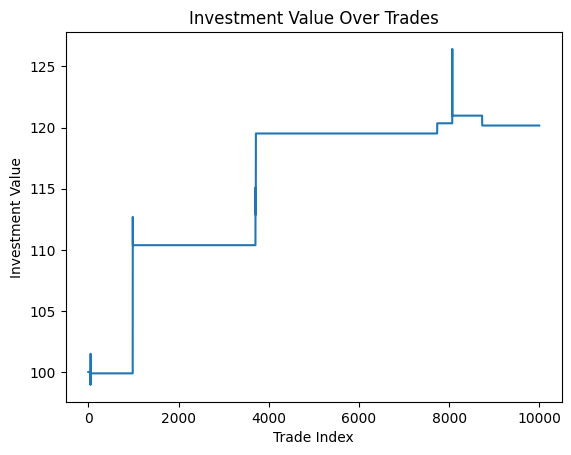

In [14]:
############### ANALYSIS OF TRADING USING CLOSING PRICE ################################

# --- Constants ---
MINIMUM_PROBABILITY = 0.9
TRADING_FEE = 0.25
LEVERAGE = 1

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
wrong_trades = 0

all_trades = []
good_trades = []
bad_trades = []
investment_value = 100
investment_history = []


# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        true_close = (validation_dataset[f"{TICKER}:close4"][idx + 1] - TRADING_FEE) * LEVERAGE
        
        if true_close >= 0:
            correct_trades += 1
            good_trades.append(true_close)
        else:
            bad_trades.append(true_close)



        total_trades += 1
        all_trades.append(true_close)

        investment_value *= 1 + (true_close / 100)
        investment_history.append(investment_value)
    
    else:
        investment_history.append(investment_value)

            

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print("-" * 34)

print(f"MEAN GOOD TRADES: {st.mean(good_trades)}")
print(f"MEAN BAD TRADES: {st.mean(bad_trades)}")
print(f"INVESTMENT VALUE {investment_value}")

# investtt = 100
# investment_history2 = []
# for trade in all_trades:
#     investtt *= 1 + (trade / 100)
#     investment_history2.append(investtt)
#     # print(trade)

# print(f"RETURN: {round(investtt - 100, 3)} %")


from matplotlib import pyplot as plt
# --- Plot the investment history ---


plt.plot(investment_history)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()